# Implementação básica do algoritmo k-means

Em grande parte baseada na implementação disponível em [dataquestio/kmeans](https://github.com/dataquestio/project-walkthroughs/tree/master/kmeans)

## Imports e Variáveis Globais

In [2]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output



PLOT_RESULTS = True
DEBUG = True

N = 100000
D = 7

K = 5
MAX_ITERATIONS = 500

## Criando o Dataset

- `N` datapoints
- Datapoints `D`-dimensionais
- Floats randomizados ➡ intervalo de [1, 10) (ou [1, 10], dependendo da método de arredondamento de float usado. Isto não deve ter nenhuma relevância estatística, no entanto)

In [3]:
dataset  = [[np.random.uniform(1, 10) for _ in range(D)] for _ in range(N)]
dataset = pd.DataFrame(dataset, columns=[f'd{i}' for i in range(D)])
dataset

,d0,d1,d2,d3,d4,d5,d6
0,8.211998,1.414655,3.884058,6.873534,6.868683,2.624929,1.636473
1,7.593488,8.455637,3.603202,3.619481,7.467344,9.048136,2.086565
2,5.454702,8.657363,2.043463,2.354291,1.678288,2.004441,8.647747
3,8.296888,7.535234,8.486536,3.419966,1.465097,4.563885,5.297830
4,7.266522,7.420230,6.420805,5.286018,9.468661,5.500486,9.765660
...,...,...,...,...,...,...,...
99995,4.979246,2.194312,2.435673,7.699911,7.450518,5.946611,3.573285
99996,5.721656,1.706624,5.048054,4.862607,3.789520,1.735710,5.491292
99997,9.868258,2.407185,9.601406,5.931309,7.841998,2.911998,7.352656
99998,9.552132,3.991223,1.466754,4.905416,5.122385,2.479383,2.552200


## K-Means (CPU)

In [4]:
def kMeansCPU(dataset:pd.DataFrame, k=3, maxIter=100, plotResults=False, debug=False):
    if plotResults:
        # Inicializando variáveis para exibição gráfica
        pca = PCA(n_components=2) # dois eixos no gráfico
        dataset_2D = pca.fit_transform(dataset)

    # Gerando centróides iniciais randomicamente
    centroids = pd.concat([(dataset.apply(lambda x: float(x.sample().iloc[0]))) for _ in range(k)], axis=1) # * Paralelizar isto provavelmente é irrelevante, visto que sempre teremos poucos centróides
    centroids_OLD = pd.DataFrame()

    iteration = 1

    while iteration <= maxIter and not centroids_OLD.equals(centroids):
        if plotResults or debug: clear_output(wait=True)
        if debug: debugStr = f'Iteration {iteration}\n\nCentroids:\n{centroids.T}\n\n'

        # Para cada datapoint, calcular distâncias entre ele e cada centróide; depois, encontrar o centróide mais próximo e salvar seu index
        distances = centroids.apply(lambda x: np.sqrt(((dataset - x) ** 2).sum(axis=1))) # ! Parte altamente paralelizável!
        if debug: debugStr += f'Distances:\n{distances}\n\n'
        closestCent = distances.idxmin(axis=1)
        del distances
        if debug: debugStr += f'Closest centroid index:\n{closestCent}\n\n'

        centroids_OLD = centroids
        centroids = dataset.groupby(closestCent).apply(lambda x: np.exp(np.log(x).mean())).T # ! Parte altamente paralelizável!

        if plotResults:
            # Plotando clusters
            centroids_2D = pca.transform(centroids.T)
            plt.title(f'Iteration {iteration}')
            plt.scatter(x=dataset_2D[:,0], y=dataset_2D[:,1], c=closestCent)
            plt.scatter(x=centroids_2D[:,0], y=centroids_2D[:,1], marker='+', linewidths=2, color='red')
            plt.show()

        if debug: print(debugStr)

        iteration += 1

    return (closestCent, centroids.T)

In [5]:
# ! Descomente para rodar de fato
# result, centroids = kMeansCPU(dataset, K, MAX_ITERATIONS, PLOT_RESULTS, DEBUG)

# Testando com um Dataset Real (Pequeno) — *Iris*

Vamos agora testar esta implementação do k-means usando um dataset real de tamanho bem trivial.

Utilizaremos o [*Iris* Data Set](https://archive.ics.uci.edu/ml/datasets/Iris), que consiste de dados a respeito de espécimes de [flores do gênero Íris](https://pt.wikipedia.org/wiki/Iris_(g%C3%A9nero)), popularmente chamadas de **Lírios**.

## Dataset

O *Iris* consiste em **150 instâncias**, com dados multivariados de **quatro atributos**:

1. Comprimento da sépala em centímetros
2. Largura da sépala em centímetros
3. Comprimento da pétala em centímetros
4. Largura da pétala em centímetros

Há também um quinto atributo de **Classe**, o **tipo da planta**, que é o que esperamos predizer utilizando o algoritmo. Há **três classes** neste dataset:

- Iris Setosa
- Iris Versicolour
- Iris Virginica

Assim, temos nossas variáveis para execução do k-means:

- `N` = 150
- `D` = 4
- `K` = 3

### Carregando o Dataset

In [6]:
# Imports
from os.path import exists as os_path_exists
from urllib.request import urlopen



# Novas variáveis globais
MAX_ITERATIONS = 100
PLOT_RESULTS = True
DEBUG = True
# ? K será inferido pela quantidade de classes no dataset
# // K = 3



# Função auxiliar
def downloadFileIfNeeded(filePath, url):
    if not os_path_exists(filePath):
        with urlopen(url) as f:
            html = f.read().decode('utf-8')
        with open(filePath, 'w') as f:
            f.write(html)



datasetUrl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
datasetFilePath = './iris.data'
columnNames = ['sepalLen', 'sepalWid', 'petalLen', 'petalWid', 'class']

# Baixando dataset diretamente da internet, se necessário
downloadFileIfNeeded(datasetFilePath, datasetUrl)

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames)

print(dataset)

     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


### Preparando o Dataset

In [7]:
# Transformando a coluna "class" em números (0, 1, …)
classFactorized = dataset['class'].factorize()
# Salvando os nomes de classe na ordem usada pelo .factorize()
classes = list(classFactorized[1])
# Sobrescrevendo a coluna do dataset pelos indexes obtidos
dataset['class'] = classFactorized[0]

print(f'##### Dataset #####\n{dataset}\n\n')

# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
dataset = ((dataset - dataset.min()) / (dataset.max() - dataset.min())) * 9 + 1

print(f'##### Dataset (normalizado, intervalo [1, 10]) #####\n{dataset}')

# Inferindo número de grupos pela quantidade de classes no dataset
K = len(classes)

##### Dataset #####
     sepalLen  sepalWid  petalLen  petalWid  class
0         5.1       3.5       1.4       0.2      0
1         4.9       3.0       1.4       0.2      0
2         4.7       3.2       1.3       0.2      0
3         4.6       3.1       1.5       0.2      0
4         5.0       3.6       1.4       0.2      0
..        ...       ...       ...       ...    ...
145       6.7       3.0       5.2       2.3      2
146       6.3       2.5       5.0       1.9      2
147       6.5       3.0       5.2       2.0      2
148       6.2       3.4       5.4       2.3      2
149       5.9       3.0       5.1       1.8      2

[150 rows x 5 columns]


##### Dataset (normalizado, intervalo [1, 10]) #####
     sepalLen  sepalWid  petalLen  petalWid  class
0        3.00     6.625  1.610169     1.375    1.0
1        2.50     4.750  1.610169     1.375    1.0
2        2.00     5.500  1.457627     1.375    1.0
3        1.75     5.125  1.762712     1.375    1.0
4        2.75     7.000  1.610169 

## Rodando o K-Means

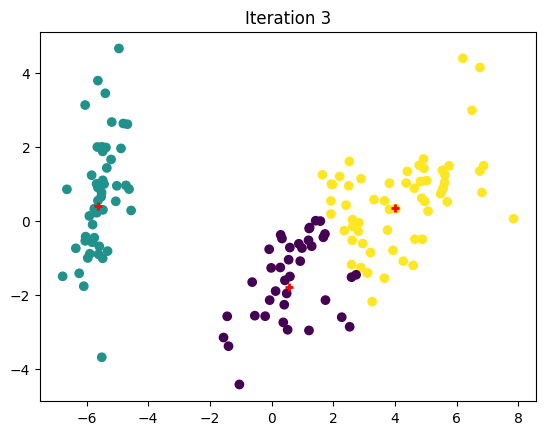

Iteration 3

Centroids:
   sepalLen  sepalWid  petalLen  petalWid
0  4.406264  3.218262  5.776541  5.361460
1  2.613660  6.143529  1.686990  1.494296
2  6.653880  4.714525  7.627264  7.778481

Distances:
            0          1          2
0    6.843534   0.633408   9.706222
1    6.263432   1.405338   9.719361
2    6.748430   0.926038  10.067004
3    6.534070   1.342861   9.980685
4    7.091915   0.878785   9.882999
..        ...        ...        ...
145  5.181902  10.679365   1.528083
146  3.181035   9.518584   2.021990
147  4.126110   9.681312   0.440030
148  5.464731  10.310093   2.312403
149  2.989427   8.556487   1.743136

[150 rows x 3 columns]

Closest centroid index:
0      1
1      1
2      1
3      1
4      1
      ..
145    2
146    2
147    2
148    2
149    2
Length: 150, dtype: int64




In [8]:
# Rodando kMeansCPU, excluindo a coluna class
result, centroids = kMeansCPU(dataset.drop(['class'], axis=1), K, MAX_ITERATIONS, PLOT_RESULTS, DEBUG)

## Conferindo Resultados

Com a tabela `ClosestCentroids` em mãos, temos a classificação de cada instância do dataset *Iris* e, assim, podemos conferir os resultados obtidos através do k-means.

Para isto, basta comparar a segunda coluna da tabela devolvida pelo `kMeansCPU()` com a última coluna do dataset Iris, que informa a classe correta de cada instância.

Essa comparação, no entanto, não é tão simplória de se realizar. Não há como sabermos qual o mapeamento correto entre a classificação feita pelo k-means e as classes reais das instâncias do dataset. Isto é, não há como discernir se o `1` na coluna de classificação de centróides se refere a uma identificação de uma `Iris-versicolor` ao invés de uma `Iris-virginica`, por exemplo.

Por isso, temos que realizar o **maximum matching** atingido pelo resultado do k-means, para realizar uma avaliação justa de seu desempenho.

### Maximum Matching

Teremos que avaliar todas as possibilidades de *mapeamento centróide–classe* e considerar apenas aquela que gera o melhor resultado.

Para isso, é necessário calcular os acertos do resultado diversas vezes. Como há $ k! $ maneiras de se interpretar `K` centróides, isto irá gerar um custo computacional de $ n \cdot k! $ operações de comparação entre classificações.

In [10]:
print(classes)
print(centroids)
print(result)

# ? instance matching
# ? maximum matching

# Como não sabemos

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
   sepalLen  sepalWid  petalLen  petalWid
0  4.406264  3.218262  5.776541  5.361460
1  2.613660  6.143529  1.686990  1.494296
2  6.653880  4.714525  7.627264  7.778481
0      1
1      1
2      1
3      1
4      1
      ..
145    2
146    2
147    2
148    2
149    2
Length: 150, dtype: int64
